In [1]:
from IPython.display import display
from dateutil.parser import parse
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import random

random.seed(123)
plt.style.use('ggplot')
% matplotlib inline

RAINBOW_COLORS = lambda v: cm.rainbow(np.linspace(0, 1, v))

In [2]:
movie_data = pd.read_csv('../movie_data.csv')

In [3]:
date_parser = lambda i: parse(i) if i is not np.nan else np.nan
movie_data.reviewer = movie_data.reviewer.astype('category')
movie_data.review_date = movie_data.review_date.apply(date_parser)
movie_data.release_date = movie_data.release_date.apply(date_parser)
movie_data.user_acclaim = movie_data.user_acclaim.astype('category')
movie_data.director = movie_data.director.astype('category')
movie_data.languages = movie_data.languages.astype('category')
movie_data.release_decade = movie_data.release_decade.astype('category')

# Parte 1 — The New York Times

In [4]:
reviewerQtd = movie_data.groupby('reviewer')['reviewer'].count()
fourReviewers = reviewerQtd.nlargest(4)
fourReviewers = [i for i in fourReviewers.index.values]

getfourReviewers = lambda i: i[2] in fourReviewers
topReviewersDF = movie_data[list(map(getfourReviewers, movie_data.itertuples()))]
topReviewersDF.reviewer.cat.remove_unused_categories(inplace=True)
topReviewersDF = topReviewersDF.reset_index(drop=True).dropna()

model = smf.ols(formula='metascore ~ C(reviewer)', data=topReviewersDF).fit()
result = pd.concat([model.params, model.bse, model.tvalues, model.pvalues],
                   axis=1, keys=['coef','SE','t','p-value'])
display(result)

,coef,SE,t,p-value
Intercept,65.768902,0.623313,105.515104,0.000000e+00
C(reviewer)[T.Jeannette Catsoulis],-12.088346,1.009437,-11.975340,4.378162e-32
C(reviewer)[T.Manohla Dargis],-2.926021,0.913382,-3.203503,1.376558e-03
C(reviewer)[T.Stephen Holden],-8.541978,0.955129,-8.943270,7.674626e-19


In [5]:
model = smf.ols(formula='review_score ~ C(reviewer)', data=topReviewersDF).fit()
result = pd.concat([model.params, model.bse, model.tvalues, model.pvalues],
                   axis=1, keys=['coef','SE','t','p-value'])
display(result)

,coef,SE,t,p-value
Intercept,68.573466,0.850775,80.601134,0.000000e+00
C(reviewer)[T.Jeannette Catsoulis],-13.480874,1.377806,-9.784306,3.598390e-22
C(reviewer)[T.Manohla Dargis],-3.401617,1.246698,-2.728501,6.411540e-03
C(reviewer)[T.Stephen Holden],-8.438851,1.303680,-6.473098,1.173811e-10


Para a concretização de nossas análises, realizamos a seleção dos quatro principais críticos do The New York Times presentes em nosso conjunto de dados. Ao aplicar o *Intercept* ao primeiro crítico dentre as categorias (A.O Scott), estima-se cerca de 65~70 pontos tanto para o escore da resenha quanto para o Metascore do filme avaliado. Em relação à este, a crítica Jeannette Catsoulis tende a atribuir notas bem mais negativas em suas avaliações e, consequentemente, influencia negativamente no Metascore. O mesmo raciocínio segue para os demais críticos.

In [6]:
model.f_pvalue

3.6467729274822127e-23

Ao mesmo tempo, uma rápida análise da F-statistic nos permite dizer que a inclusão destas variáveis (em outras palavras, a consideração das categorias de críticos) está nos ajudando a melhorar a qualidade de nosso modelo. Isso se deve ao fato de que uma influência negativa do Metascore não significa que esta é uma relação desfavorável — pelo contrário, se um crítico atribui mais notas negativas em suas avaliações, uma redução concomitante do Metascore significa que este ainda é ativamente influente.

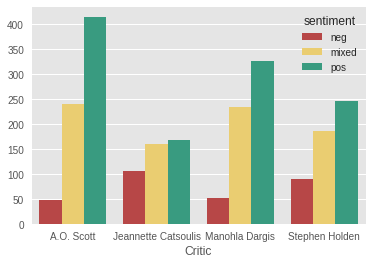

In [7]:
sentPerCritic = topReviewersDF.groupby(['reviewer', 'sentiment']).review_score.count()
sentPerCritic = pd.DataFrame(sentPerCritic).reset_index()
sentPerCritic.reviewer = sentPerCritic.reviewer.cat.remove_unused_categories()

review_palette = ['#CA3435', '#FED85D', '#29AB87']
sns.set_palette(review_palette)
sns.barplot(x='reviewer', y='review_score', hue='sentiment', 
            data=sentPerCritic, hue_order=['neg', 'mixed', 'pos'])
t = plt.xlabel('Critic'); t = plt.ylabel("")

Por sua vez, uma análise mais cuidadosa nos permite identificar que o crítico utilizado como base para o *Intercept* — ou o A.O Scott — atribui uma quantidade substancial de avaliações positivas em relação aos demais. Assim sendo, também é possível verificar que críticos como a Jeannette Catsoulis apresentam um maior balanceamento de notas, com menos da metade de avaliações positivas em relação ao A.O Scott e pouco mais do dobro de avaliações negativas em relação ao mesmo. 

In [8]:
model = smf.ols(formula='metascore ~ C(reviewer):C(sentiment)', data=topReviewersDF).fit()
result = pd.concat([model.params, model.bse, model.tvalues, model.pvalues],
                    axis=1, keys=['coef','SE','t','p-value'])
display(result)

,coef,SE,t,p-value
Intercept,56.250000,0.717279,78.421364,0.000000e+00
C(sentiment)[T.neg],-18.122340,1.772475,-10.224313,5.120661e-24
C(sentiment)[T.pos],18.175121,0.901523,20.160461,3.117044e-83
C(reviewer)[T.Jeannette Catsoulis]:C(sentiment)[mixed],-4.797170,1.136256,-4.221911,2.518615e-05
C(reviewer)[T.Manohla Dargis]:C(sentiment)[mixed],-1.750000,1.020868,-1.714228,8.662440e-02
C(reviewer)[T.Stephen Holden]:C(sentiment)[mixed],-4.925676,1.087168,-4.530739,6.185020e-06
C(reviewer)[T.Jeannette Catsoulis]:C(sentiment)[neg],-5.740867,1.947321,-2.948084,3.230393e-03
C(reviewer)[T.Manohla Dargis]:C(sentiment)[neg],2.930033,2.236458,1.310122,1.902882e-01
C(reviewer)[T.Stephen Holden]:C(sentiment)[neg],-2.949882,1.999788,-1.475098,1.403261e-01
C(reviewer)[T.Jeannette Catsoulis]:C(sentiment)[pos],-5.107756,1.018646,-5.014258,5.739222e-07


Considerando-se o A.O Scott como *Intercept*, é possível ver que este costuma atribuir notas positivas mais altas em suas resenhas do que em comparação à outros críticos. Quanto às avaliações negativas, estima-se que Jeannette Catsoulis atribua as menores notas. Já entre o polo de reviews mistas, Stephen Holden atribui as menores, enquanto A.O Scott introduz, novamente, notas superiores.

Nota-se que, em alguns casos, o baixo valor dos p-values nos impossibilita de rejeitar a hipótese nula. O p-value da F-statistic, por sua vez, nos mostra que estamos melhorando consideravelmente a qualidade de nosso modelo. Assim sendo, é provável que haja alguma variável inerente ao filme que esteja moldando relações internamente. A partir deste momento, direcionaremos nossas análises objetivando encontrá-las.

# Parte 2 — Gêneros

Entre nossas hipóteses iniciais se encontrava o gênero do filme. Para prosseguir com nossas análises, iremos primeiro verificar a distribuição interna dos principais gêneros conforme ambas as variáveis dependentes que objetivamos anteriormente — o escore do The New York Times e o Metascore.

In [9]:
genres = movie_data.columns[12:-1].drop('unknown')
fiveGenres = movie_data[genres].sum().nlargest(5)
fiveGenres = [i for i in fiveGenres.index.values]

meta_content = {}; review_content = {}
for genre in fiveGenres:
    meta = movie_data.groupby(genre)['metascore']
    review = movie_data.groupby(genre)['review_score']
    meta_content[genre] = meta.get_group(1).values
    review_content[genre] = review.get_group(1).values
    
fiveGenresMeta = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in meta_content.items()])).reset_index(drop=True)
fiveGenresReviews = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in review_content.items()])).reset_index(drop=True)

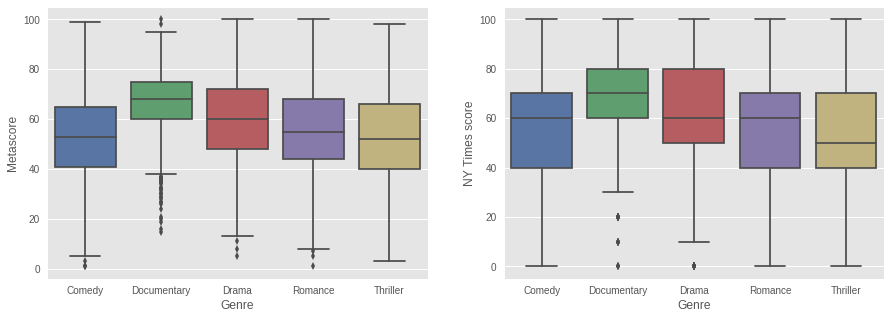

In [10]:
sns.set_palette('deep')
fig, axes = plt.subplots(ncols=2, figsize=(15,5))
sns.boxplot(data=fiveGenresMeta.dropna(), ax=axes[0])
sns.boxplot(data=fiveGenresReviews.dropna(), ax=axes[1])
axes[0].set_ylabel('Metascore'); axes[1].set_ylabel('NY Times score')
for axis in axes: axis.set_xlabel('Genre')

É possível verificar que a distribuição do Metascore se apresenta heterogênea para a maioria dos principais gêneros. Apesar disso, é possível verificar que a amplitude interquartil dos filmes de comédia e de suspense, por exemplo, se concentram mais em escores mistos, enquanto os filmes de drama estão bem distribuídos entre positivos e mistos, centrando melhor em torno do escore médio adotado pelo site (60). Em contraste, os documentários se apresentam mais homogêneos e centrados em torno de notas positivas — apesar de estes também possuírem uma quantidade maior de *outliners*.

Já entre as reviews do The New York Times, podemos ver que há um pouco mais de heterogeneidade e uma redução do número de *outliners*. Não obstante, também pode-se observar que existem gêneros, a exemplo dos filmes de drama e de romance, de igual mediana, mas com amplitudes interquartis significativamente diferentes — voltadas mais para escores positivos e mais para escores mistos, respectivamente. Similarmente, também há filmes de amplitude interquartil similar, mas com medianas diferentes.

In [11]:
model = smf.ols('metascore ~ ' + ' + '.join(fiveGenres), topReviewersDF).fit()
result = pd.concat([model.params, model.bse, model.tvalues, model.pvalues],
                    axis=1, keys=['coef', 'SE', 't', 'p-value'])
display(result)

,coef,SE,t,p-value
Intercept,56.562464,0.840976,67.258091,0.000000e+00
Drama,7.286853,0.778736,9.357280,1.907349e-20
Comedy,-1.837939,0.838796,-2.191163,2.854188e-02
Thriller,-4.321605,0.849790,-5.085495,3.968513e-07
Documentary,15.562309,1.263903,12.312900,9.115278e-34
Romance,-2.358000,1.037223,-2.273378,2.309693e-02


In [12]:
model = smf.ols('metascore ~ Romance', movie_data).fit()
result = pd.concat([model.params, model.bse, model.tvalues, model.pvalues],
                    axis=1, keys=['coef', 'SE', 't', 'p-value'])
display(result)

,coef,SE,t,p-value
Intercept,57.898848,0.174006,332.74114,0.000000e+00
Romance,-2.445535,0.423488,-5.77474,7.901647e-09


Conforme os resultados verificados acima, é possível concluir que a categorização do filme como um documentário é habitualmente associada a um Metascore mais alto. Em contraste, filmes de suspense se encontram associados a escores mais baixos. Por fim, é possível verificar que os filmes de romance não são contemplados com um p-value muito baixo. Porém, uma análise mais cuidadosa e considerando somente os filmes de romance revela que este o possui. Isso se deve ao fato de que, entre os principais gêneros, existe uma correlação entre os filmes de romance e outros gêneros principais, como veremos mais adiante.

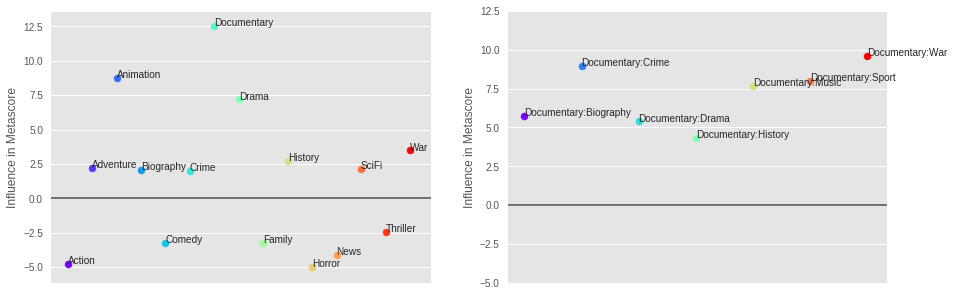

In [13]:
documentary_types = genres.drop('Documentary')

general = smf.ols('metascore ~ ' + ' + '.join(genres), movie_data).fit()
documentaries = smf.ols('metascore ~ Documentary:(' + ' + '.join(documentary_types) + ')', 
                        movie_data).fit()

fig, axes = plt.subplots(ncols=2, figsize=(15,5))
for model, axis in zip([general, documentaries], axes):
    result = pd.concat([model.params, model.bse, model.tvalues, model.pvalues],
                        axis=1, keys=['coef', 'SE', 't', 'p-value'])
    result = result[result['p-value'] < 0.01].drop('Intercept')

    for i, j, color in zip(range(15), result.coef, RAINBOW_COLORS(len(result))):
        axis.scatter(i, j, color=color)
    for i, txt in enumerate(result.index):
        axis.annotate(txt, (range(15)[i], result.coef[i]))
    axis.set_ylabel('Influence in Metascore')
    t = axis.set_xticks([])
    axis.axhline(0, color='black', alpha=0.6)
    
t = axes[1].set_yticks(np.arange(-5, 12.6, 2.5))
plt.savefig('../observations/score-infl-per-genre.png')

Em uma escala de primeiro nível, é vísivel que os documentários, filmes de animação e de drama estão associados a Metascores maiores, enquanto filmes de ação e de terror se encontram associados a Metascores abaixo do que o habitual. Apesar disso, como veremos mais abaixo, isso não significa que um filme que pertence aos três gêneros mais bem-avaliados simultaneamente possuirá um Metascore significativamente maior, visto que a associação entre estes gêneros é incomum e que estamos tratando apenas de escalas de primeiro nível.

Já em escalas de segundo nível, podemos ver que os documentários diferem internamente. É possível ver que documentários de guerra são associados a escores mais altos do que os documentários musicais, por exemplo.

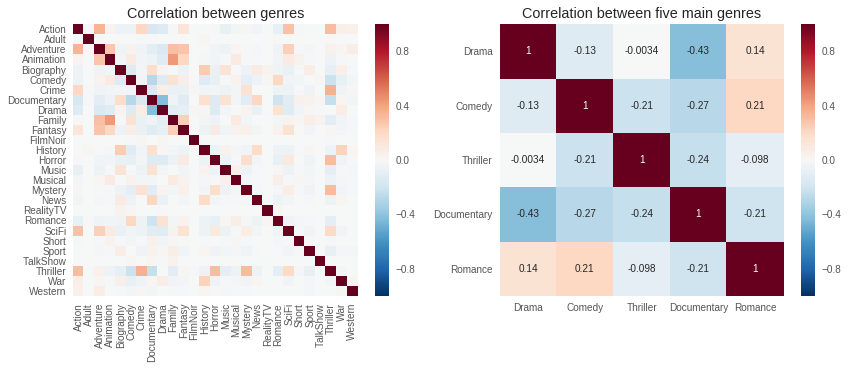

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
sns.heatmap(movie_data[genres].corr(), ax=axes[0])
sns.heatmap(movie_data[fiveGenres].corr(), annot=True, ax=axes[1])
axes[0].set_title('Correlation between genres');
axes[1].set_title('Correlation between five main genres')
t = plt.yticks(rotation=0)

Ao mesmo tempo, é possível observar que, no geral, não existe uma grande correlação entre os gêneros dos filmes. Por se tratarem de atributos primordialmente categóricos — mas representados como binários —, uma correlação forte e positiva entre dois elementos (x e y) significa que a presença de x é frequentemente associada à presença de y. Logo, é esperado que não haja uma ampla correlação, visto que se tratam de ligações incomuns de serem estabelecidas. Ainda assim, podemos verificar algumas relações, a exemplo de filmes de ação que são constantemente associados a filmes de aventura, ou filmes de animação que são constantemente associados a filmes voltados à família.

Por outro lado, ao considerar somente os cinco principais gêneros, é possível verificar que estes são majoritariamente independentes, onde a presença de um gênero é constantemente associada a ausência de outro ou onde não há uma correlação propriamente dita. A única ressalva, conforme visto anteriormente no modelo de regressão, fica para os filmes de romance, que se encontram razoavelmente associados aos filmes de drama e de comédia.

# Parte 3.1 — De volta ao The New York Times

Conforme vimos pouco acima, a consideração do gênero é um fator de influência para analisarmos os escores, visto que sua distribuição difere internamente conforme os mesmos. Assim, continuaremos nossas análises de onde paramos — desta vez, levando os gêneros dos filmes em conta.

In [15]:
fiveGenres = ' + '.join(fiveGenres)
formula = 'metascore ~ C(reviewer):C(sentiment):({})'.format(fiveGenres)
model = smf.ols(formula, topReviewersDF).fit()
display(model.f_pvalue)

4.3502295335770214e-316

In [16]:
result = pd.concat([model.params, model.bse, model.tvalues, model.pvalues],
                    axis=1, keys=['coef', 'SE', 't', 'p-value'])
display(result[result['p-value'] < 0.01].T)

,Intercept,C(reviewer)[Stephen Holden]:C(sentiment)[mixed]:Drama,C(reviewer)[A.O. Scott]:C(sentiment)[neg]:Drama,C(reviewer)[Jeannette Catsoulis]:C(sentiment)[neg]:Drama,C(reviewer)[Manohla Dargis]:C(sentiment)[neg]:Drama,C(reviewer)[Stephen Holden]:C(sentiment)[neg]:Drama,C(reviewer)[A.O. Scott]:C(sentiment)[pos]:Drama,C(reviewer)[Jeannette Catsoulis]:C(sentiment)[pos]:Drama,C(reviewer)[Manohla Dargis]:C(sentiment)[pos]:Drama,C(reviewer)[Stephen Holden]:C(sentiment)[pos]:Drama,...,C(reviewer)[Manohla Dargis]:C(sentiment)[neg]:Thriller,C(reviewer)[Stephen Holden]:C(sentiment)[neg]:Thriller,C(reviewer)[Manohla Dargis]:C(sentiment)[mixed]:Documentary,C(reviewer)[Jeannette Catsoulis]:C(sentiment)[neg]:Documentary,C(reviewer)[Stephen Holden]:C(sentiment)[neg]:Documentary,C(reviewer)[A.O. Scott]:C(sentiment)[pos]:Documentary,C(reviewer)[Jeannette Catsoulis]:C(sentiment)[pos]:Documentary,C(reviewer)[Manohla Dargis]:C(sentiment)[pos]:Documentary,C(reviewer)[Stephen Holden]:C(sentiment)[pos]:Documentary,C(reviewer)[Stephen Holden]:C(sentiment)[neg]:Romance
coef,57.998538,-3.647923,-14.039195,-1.296674e+01,-9.006723,-9.878860e+00,1.488817e+01,8.585674e+00,1.180448e+01,1.047685e+01,...,-10.554606,-1.645800e+01,13.504783,-17.498538,1.173780e-14,1.870193e+01,1.513537e+01,1.942895e+01,1.457001e+01,-9.509540
SE,0.635236,1.303019,3.150388,2.047739e+00,3.185396,1.996030e+00,9.729777e-01,1.547938e+00,1.101833e+00,1.189856e+00,...,2.911961,2.424719e+00,3.801302,4.887521,3.759335e-15,1.741408e+00,1.904277e+00,1.885509e+00,1.836105e+00,3.267912
t,91.302285,-2.799593,-4.456339,-6.332227e+00,-2.827505,-4.949254e+00,1.530165e+01,5.546524e+00,1.071350e+01,8.805141e+00,...,-3.624570,-6.787591e+00,3.552673,-3.580248,3.122308e+00,1.073954e+01,7.948093e+00,1.030435e+01,7.935283e+00,-2.909974
p-value,0.000000,0.005161,0.000009,2.919275e-10,0.004734,8.013768e-07,2.609774e-50,3.263162e-08,3.822516e-26,2.587703e-18,...,0.000296,1.460547e-11,0.000389,0.000351,1.817669e-03,2.924506e-26,2.994389e-15,2.379003e-24,3.310726e-15,0.003651


Torna-se, então, visível que as avaliações feitas pelos críticos varia conforme o gênero. A exemplo da crítica Jeannette Catsoulis, percebe-se que as avaliações negativas feitas pela mesma em filmes de Drama tendem a influenciar o Metascore da estimativa padrão (cerca de 58 pontos) em cerca de 13 pontos a menos. Já para os documentários, podemos verificar que esta influência passa para 17,5 pontos. Similarmente às observações acima, outros críticos, a exemplo da Manohla Dargis, influenciam filmes de drama negativamente com uma queda de 9 pontos — três pontos a menos, se comparada com Jeannette. 

# Parte 3.2 — Escore dos usuários

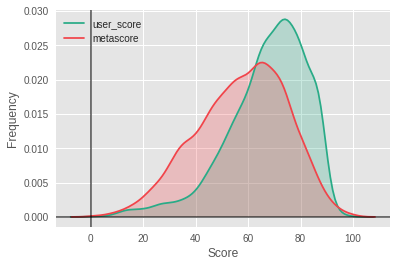

In [17]:
sns.kdeplot(movie_data.user_score.dropna(), color='#29AB87', shade=True)
sns.kdeplot(movie_data.metascore.dropna(), color='#F1444A', shade=True)

plt.axhline(0, color='black', alpha=0.6)
plt.axvline(0, color='black', alpha=0.6)
plt.xlabel('Score')
plt.ylabel('Frequency')

A distribuição de notas nos mostra que os usuários, em um panorama geral, tendem a atribuir escores mais altos e próximos de uma faixa positiva. O Metascore, por sua vez, se apresenta mais distribuído e centrado em torno de avaliações mistas e positivas, além de também possuir maior frequência de escores negativos.

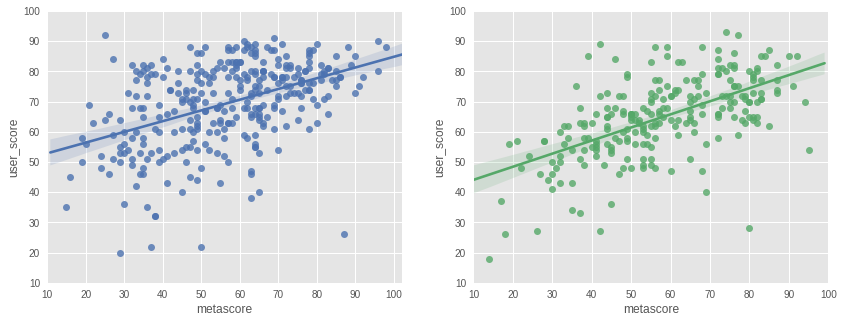

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
past_decade = movie_data[movie_data['release_decade']=='2000s'].sample(400)
now = movie_data[movie_data['release_decade']=='2010s'].sample(400)

sns.regplot('metascore', 'user_score', past_decade, ax=axes[0])
sns.regplot('metascore', 'user_score', now, ax=axes[1])
for axis in axes:
    axis.set_xticks(range(10,101,10))
    axis.set_yticks(range(10,101,10))

Conforme pode ser verificado acima, ao pegarmos uma amostra de 400 elementos, é possível ver que a influência do Metascore sobre o escore global dos usuários aumentou um pouco em relação à última década, apesar de ambas se demonstrarem igualmente pertinentes de que esta influência existe.

In [19]:
formula = 'user_score ~ C(reviewer):C(sentiment):({})'.format(fiveGenres)
model = smf.ols(formula, topReviewersDF).fit()
display(model.f_pvalue)

3.3134109870049178e-59

In [20]:
result = pd.concat([model.params, model.bse, model.tvalues, model.pvalues],
                    axis=1, keys=['coef', 'SE', 't', 'p-value'])
display(result[result['p-value'] < 0.01].T)

,Intercept,C(reviewer)[A.O. Scott]:C(sentiment)[pos]:Drama,C(reviewer)[Manohla Dargis]:C(sentiment)[pos]:Drama,C(reviewer)[A.O. Scott]:C(sentiment)[mixed]:Comedy,C(reviewer)[A.O. Scott]:C(sentiment)[neg]:Comedy,C(reviewer)[Jeannette Catsoulis]:C(sentiment)[neg]:Comedy,C(reviewer)[Stephen Holden]:C(sentiment)[neg]:Comedy,C(reviewer)[Jeannette Catsoulis]:C(sentiment)[mixed]:Thriller,C(reviewer)[A.O. Scott]:C(sentiment)[neg]:Thriller,C(reviewer)[Jeannette Catsoulis]:C(sentiment)[neg]:Thriller,C(reviewer)[Stephen Holden]:C(sentiment)[neg]:Thriller,C(reviewer)[Manohla Dargis]:C(sentiment)[mixed]:Documentary,C(reviewer)[Stephen Holden]:C(sentiment)[neg]:Documentary,C(reviewer)[A.O. Scott]:C(sentiment)[pos]:Documentary,C(reviewer)[Jeannette Catsoulis]:C(sentiment)[pos]:Documentary,C(reviewer)[Manohla Dargis]:C(sentiment)[pos]:Documentary,C(reviewer)[Stephen Holden]:C(sentiment)[pos]:Documentary
coef,64.855234,5.685683e+00,4.952182,-3.868204,-10.942739,-12.300843,-6.105699,-4.521459,-9.357069,-1.517589e+01,-8.043346,13.014581,1.023589e-14,5.041408,6.052075,9.266244e+00,7.649141
SE,0.611071,9.359639e-01,1.059917,1.405158,3.117392,2.767499,2.138285,1.619303,3.490474,1.889907e+00,2.332478,3.656694,3.616323e-15,1.675161,1.831834,1.813781e+00,1.766256
t,106.133737,6.074683e+00,4.672236,-2.752861,-3.510223,-4.444750,-2.855419,-2.792225,-2.680745,-8.029963e+00,-3.448412,3.559112,2.830468e+00,3.009506,3.303833,5.108801e+00,4.330709
p-value,0.000000,1.459197e-09,0.000003,0.005956,0.000457,0.000009,0.004338,0.005280,0.007401,1.570532e-15,0.000574,0.000380,4.690105e-03,0.002646,0.000969,3.520659e-07,0.000016


Assim como fizemos com o Metascore mais acima, também é possível ver que a influência no escore dos usuários varia conforme o gênero, o crítico e o sentimento da avaliação. O sentimento negativo de Stephen Holden para filmes de suspense, por exemplo, tende a influenciar o Metascore em 8 pontos a menos. Nos mesmos parâmetros, Jeannette Catsoulis possui uma influência de 15 pontos a menos no Metascore. O *p-value* da *F-statistic*, mais uma vez, nos mostra que estamos melhorando nosso modelo com a consideração destas variáveis. Seguiremos, então, em busca de outras características que possam ser de influência.

# Parte 4.1 — Idioma

In [21]:
languagesQtd = movie_data.groupby('languages')[['metascore']].count().drop('unknown')
fiveLanguages = languagesQtd.nlargest(5, ['metascore'])
fiveLanguages = [i for i in fiveLanguages.index.values]

In [22]:
getFiveLanguages = lambda i: i[12] in fiveLanguages
topLanguagesDF = movie_data[list(map(getFiveLanguages, movie_data.itertuples()))]
topLanguagesDF.languages.cat.remove_unused_categories(inplace=True)
topLanguagesDF = topLanguagesDF.reset_index(drop=True).dropna()

In [23]:
model = smf.ols(formula='metascore ~ C(languages)', data=topLanguagesDF).fit()

result = pd.concat([model.params, model.bse, model.tvalues, model.pvalues],
                   axis=1, keys=['coef','SE','t','p-value'])
display(result)
display(model.f_pvalue)

,coef,SE,t,p-value
Intercept,55.890741,0.331071,168.817936,0.000000e+00
C(languages)[T.French],13.541951,1.755169,7.715467,1.622095e-14
C(languages)[T.German],13.938527,2.765110,5.040858,4.905487e-07
C(languages)[T.Japanese],14.109259,2.798971,5.040874,4.905096e-07
C(languages)[T.Spanish],11.309259,2.641202,4.281861,1.910654e-05


6.2971211145582876e-25

Apesar de, em um primeiro momento, não termos observado uma correlação entre os idiomas, uma análise mais cuidadosa, selecionando os cinco principais idiomas, nos mostra claramente que há uma relação. O baixo *p-value* nos permite concluir que também estamos melhorando nosso modelo. Podemos também realizar a observação da distribuições.

In [24]:
meta_content = {}; review_content = {}
for lang in fiveLanguages:
    meta = movie_data.groupby('languages')['metascore']
    review = movie_data.groupby('languages')['review_score']
    meta_content[lang] = meta.get_group(lang).values
    review_content[lang] = review.get_group(lang).values
    
fiveLangsMeta = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in meta_content.items()])).reset_index(drop=True)
fiveLangsReviews = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in review_content.items()])).reset_index(drop=True)

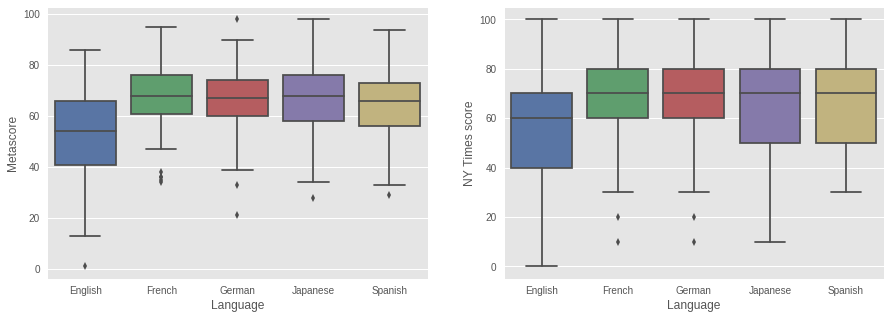

In [25]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5))
sns.boxplot(data=fiveLangsMeta.dropna(), ax=axes[0])
sns.boxplot(data=fiveLangsReviews.dropna(), ax=axes[1])
axes[0].set_ylabel('Metascore'); axes[1].set_ylabel('NY Times score')
for axis in axes: axis.set_xlabel('Language')

É possível ver que a distribuição das avaliações do The New York Times por idioma se apresenta mais heterogênea do que as distribuições dos Metascores. Em ambos os casos, é possível ver que os filmes dos outros idiomas principais se encontram associados a escores maiores do que os filmes em inglês. Em especial, a distribuição do Metascore em filmes franceses e alemães se encontram bem homogêneas e centradas em torno do polo positivo de resenhas.

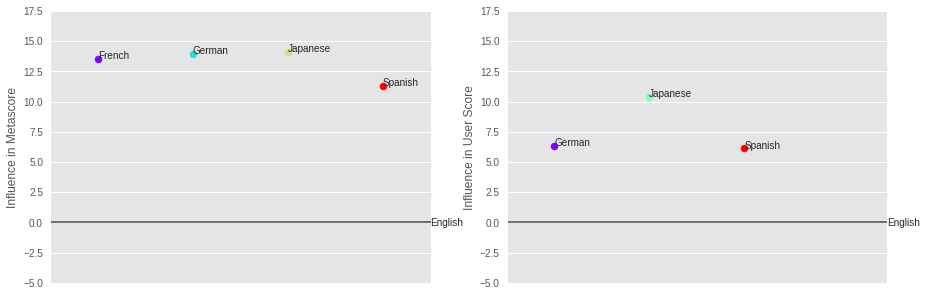

In [26]:
meta = smf.ols('metascore ~ C(languages)', topLanguagesDF).fit()
user = smf.ols('user_score ~ C(languages)', topLanguagesDF).fit()

fig, axes = plt.subplots(ncols=2, figsize=(15,5))
for axis, model in zip(axes, [meta, user]):
    result = pd.concat([model.params, model.bse, model.tvalues, model.pvalues],
                        axis=1, keys=['coef', 'SE', 't', 'p-value'])
    result = result[result['p-value'] < 0.01].drop('Intercept')

    for i, j, color in zip(range(len(result)), result.coef, RAINBOW_COLORS(len(result))):
        axis.scatter(i, j, color=color)
    for i, txt in enumerate(result.index):
        txt = txt[15:-1]
        axis.annotate(txt, (range(15)[i], result.coef[i]))
    t = axis.set_xticks([]); axis.set_xlim(-0.5, 3.5)
    t = axis.set_yticks(np.arange(-5, 20, 2.5))
    axis.axhline(0, color='black', alpha=0.6)
    axis.annotate('English', (3.5, -0.3))

axes[0].set_ylabel('Influence in Metascore')
axes[1].set_ylabel('Influence in User Score')
plt.savefig('../observations/score-infl-per-lang.png')

Sumarizando o que vimos nos resultados de nosso modelo mais acima, considerando os filmes em inglês como o padrão para o *Intercept*, é possível ver que os filmes em outros idiomas tendem a possuir escores superiores. Os filmes japoneses, como vimos anteriormente, possuem a maior influência no Metascore com sua categorização, seguidos pelos filmes alemães, franceses, logo após, espanhóis. 

Já em relação ao escore dos usuários, é possível ver que os filmes japoneses aparecem com uma larga folga em relação aos demais, enquanto a diferença de influência entre filmes alemães e espanhóis diminui. Quanto aos filmes franceses, não fora possível rejeitar a hipótese nula de que estes não possuem influência. Para melhorar nossas considerações, podemos também cruzar esta relação com o gênero do filme, pois conforme já verificado, este também exerce influência no Metascore e nos escores dos usuários.

In [27]:
formula = 'metascore ~ C(languages):({})'.format(fiveGenres)
model = smf.ols(formula, topLanguagesDF).fit()
model.f_pvalue

1.2065563748513783e-107

In [28]:
result = pd.concat([model.params, model.bse, model.tvalues, model.pvalues],
                   axis=1, keys=['coef','SE','t','p-value'])
display(result[result['p-value'] < 0.01].T)

,Intercept,C(languages)[English]:Drama,C(languages)[French]:Drama,C(languages)[German]:Drama,C(languages)[Japanese]:Drama,C(languages)[Spanish]:Drama,C(languages)[English]:Thriller,C(languages)[English]:Documentary,C(languages)[French]:Documentary,C(languages)[Japanese]:Documentary
coef,51.004667,7.599810e+00,1.967389e+01,1.717875e+01,15.735145,1.594851e+01,-3.442096,1.775522e+01,22.995333,25.083618
SE,0.724150,6.789397e-01,2.190023e+00,3.265093e+00,3.412633,3.199327e+00,0.769807,1.046652e+00,8.199117,9.509808
t,70.433821,1.119364e+01,8.983416e+00,5.261336e+00,4.610852,4.984958e+00,-4.471377,1.696383e+01,2.804611,2.637658
p-value,0.000000,1.581470e-28,4.514705e-19,1.529962e-07,0.000004,6.546755e-07,0.000008,9.997075e-62,0.005070,0.008391


Agora, é possível ver que os dramas franceses exercem mais influência no Metascore do que os demais, enquanto os japoneses se saem melhor nos documentários.

In [29]:
formula = 'user_score ~ C(languages):({})'.format(fiveGenres)
model = smf.ols(formula, topLanguagesDF).fit()
model.f_pvalue

1.598014414355479e-36

In [30]:
result = pd.concat([model.params, model.bse, model.tvalues, model.pvalues],
                   axis=1, keys=['coef','SE','t','p-value'])
display(result[result['p-value'] < 0.01].T)

,Intercept,C(languages)[English]:Drama,C(languages)[French]:Drama,C(languages)[German]:Drama,C(languages)[Japanese]:Drama,C(languages)[Spanish]:Drama,C(languages)[English]:Documentary
coef,60.241963,4.679252e+00,7.402644,10.082097,11.056792,10.632245,8.919299e+00
SE,0.599868,5.624169e-01,1.814161,2.704723,2.826941,2.650243,8.670203e-01
t,100.425337,8.319899e+00,4.080477,3.727590,3.911222,4.011800,1.028730e+01
p-value,0.000000,1.315419e-16,0.000046,0.000197,0.000094,0.000062,2.022001e-24


Já nos escores dos usuários, os dramas japoneses saem em liderança, seguidos pelos dramas alemães, espanhóis, e somente após, os dramas franceses.

# Parte 4.2 — Diretor

In [31]:
directorQtd = movie_data.groupby('director')[['metascore']].count().drop('unknown')
fiveDirectors = directorQtd.nlargest(5, ['metascore'])
fiveDirectors = [i for i in fiveDirectors.index.values]

getFiveDirectors = lambda i: i[11] in fiveDirectors
topDirectorsDF = movie_data[list(map(getFiveDirectors, movie_data.itertuples()))]
topDirectorsDF.director.cat.remove_unused_categories(inplace=True)
topDirectorsDF = topDirectorsDF.reset_index(drop=True).dropna()

model = smf.ols('metascore ~ C(director)', data=topDirectorsDF).fit()
result = pd.concat([model.params, model.bse, model.tvalues, model.pvalues],
                   axis=1, keys=['coef','SE','t','p-value'])
display(result)
display(model.f_pvalue)

,coef,SE,t,p-value
Intercept,63.00,4.437449,14.197347,3.092062e-12
C(director)[T.Spike Lee],-4.80,6.275500,-0.764879,4.528539e-01
C(director)[T.Steven Soderbergh],10.00,6.008334,1.664355,1.108931e-01
C(director)[T.Steven Spielberg],13.75,6.656173,2.065752,5.141077e-02
C(director)[T.Woody Allen],1.00,6.008334,0.166435,8.694063e-01


0.050416371540606957

Por fim, ao contrário do que esperávamos, ao conduzirmos uma análise mais cuidadosa com os principais diretores, é possível ver que estes não possuem uma influência propriamente dita. Além de o *p-value* apresentado por estes ser alto — o que indica que não podemos rejeitar a hipótese de que estes não são influentes —, o alto valor da *p-value* da *F-statistic* nos indica ainda que, com a consideração destas variáveis, não é possível rejeitar a hipótese nula de que não estamos melhorando nosso modelo.